# Install detectron2

In [ ]:
!pip install pyyaml==5.1

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Run a pre-trained detectron2 model

We first download an image from the COCO dataset:

In [ ]:
!wget http://images.cocodataset.org/val2017/000000439715.jpg -q -O input.jpg
im = cv2.imread("./input.jpg")
cv2_imshow(im)

Then, we create a detectron2 config and a detectron2 `DefaultPredictor` to run inference on this image.

In [ ]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

model_final_f10217.pkl: 178MB [00:09, 18.6MB/s]                           
/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([17,  0,  0,  0,  0,  0,  0,  0, 25,  0, 25, 25,  0,  0, 24],
       device='cuda:0')
Boxes(tensor([[126.6035, 244.8977, 459.8291, 480.0000],
        [251.1083, 157.8127, 338.9731, 413.6379],
        [114.8496, 268.6864, 148.2352, 398.8111],
        [  0.8217, 281.0327,  78.6072, 478.4210],
        [ 49.3954, 274.1229,  80.1545, 342.9808],
        [561.2248, 271.5816, 596.2755, 385.2552],
        [385.9072, 270.3125, 413.7130, 304.0397],
        [515.9295, 278.3744, 562.2792, 389.3802],
        [335.2409, 251.9167, 414.7491, 275.9375],
        [350.9300, 269.2060, 386.0984, 297.9081],
        [331.6292, 230.9996, 393.2759, 257.2009],
        [510.7349, 263.2656, 570.9865, 295.9194],
        [409.0841, 271.8646, 460.5582, 356.8722],
        [506.8767, 283.3257, 529.9403, 324.0392],
        [594.5663, 283.4820, 609.0577, 311.4124]], device='cuda:0'))


In [ ]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

# Train on a custom dataset

In this section, we show how to train an existing detectron2 model on a custom dataset in a new format.

We use [the balloon segmentation dataset](https://github.com/matterport/Mask_RCNN/tree/master/samples/balloon)
which only has one class: balloon.
We'll train a balloon segmentation model from an existing model pre-trained on COCO dataset, available in detectron2's model zoo.

Note that COCO dataset does not have the "balloon" category. We'll be able to recognize this new class in a few minutes.

## Prepare the dataset

Register the balloon dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).
Here, the dataset is in its custom format, therefore we write a function to parse it and prepare it into detectron2's standard format. User should write such a function when using a dataset in custom format. See the tutorial for more details.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

Mounted at /content/drive


In [ ]:
# if your dataset is in COCO format, this cell can be replaced by the following three lines:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/content/drive/MyDrive/mask rcnn/aorta/aorta_train_anno.json", "/content/drive/MyDrive/mask rcnn/aorta/aorta_train")
register_coco_instances("my_dataset_val", {}, "/content/drive/MyDrive/mask rcnn/aorta/aorta_val_anno.json", "/content/drive/MyDrive/mask rcnn/aorta/aorta_val")

In [ ]:
aorta_train_metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts_train = DatasetCatalog.get("my_dataset_train")
aorta_val_metadata = MetadataCatalog.get("my_dataset_val")
dataset_dicts_val = DatasetCatalog.get("my_dataset_val")

## Train!

Now, let's fine-tune a COCO-pretrained R50-FPN Mask R-CNN model on the balloon dataset. It takes ~2 minutes to train 300 iterations on a P100 GPU.


In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val")
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 500    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

## Inference & evaluation using the trained model
Now, let's run inference with the trained model on the balloon validation dataset. First, let's create a predictor using the model we just trained:



In [ ]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

Then, we randomly select several samples to visualize the prediction results.

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


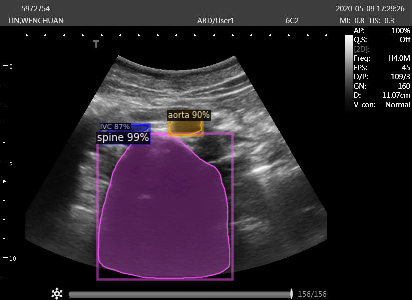

In [ ]:
from detectron2.utils.visualizer import ColorMode
filename = "/content/drive/MyDrive/mask rcnn/aorta/aorta_train/1.2.392.200036.9116.6.25.185122844805718.1248.20200509052926.1.jpg"
im = cv2.imread(filename)
outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
v = Visualizer(im[:, :, ::-1],
               metadata=aorta_train_metadata, 
               scale=0.5, 
               instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
              )
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


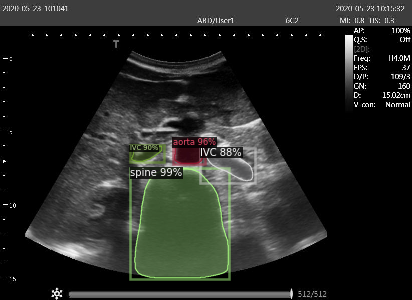

In [ ]:
filename = "/content/drive/MyDrive/mask rcnn/aorta/aorta_val/1.2.392.200036.9116.6.25.185122844805718.796.20200523101532.1.jpg"
im = cv2.imread(filename)
outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
v = Visualizer(im[:, :, ::-1],
               metadata=aorta_val_metadata, 
               scale=0.5, 
               instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
              )
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
video = "/content/drive/MyDrive/mask rcnn/aorta/aorta_1.mp4"
cap = cv2.VideoCapture(video)

fourcc = cv2.VideoWriter_fourcc(*'XVID')
output_video = cv2.VideoWriter('aorta_segmented.avi', fourcc, 12.0, (640,  480))
i=1
while cap.isOpened():
    ret, frame = cap.read()
    # if frame is read correctly ret is True
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break

    outputs = predictor(frame)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(frame[:, :, ::-1],
                   metadata=aorta_val_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
                   )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    output_video.write(out.get_image()[:, :, ::-1])
    # cv2.imwrite('/content/drive/MyDrive/mask rcnn/aorta/video_inference/output_{}.png'.format(i), out.get_image()[:, :, ::-1])
    i+=1
    if cv2.waitKey(1) == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


Can't receive frame (stream end?). Exiting ...


We can also evaluate its performance using AP metric implemented in COCO API.
This gives an AP of ~70. Not bad!

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("my_dataset_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "my_dataset_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

# Run panoptic segmentation on a video

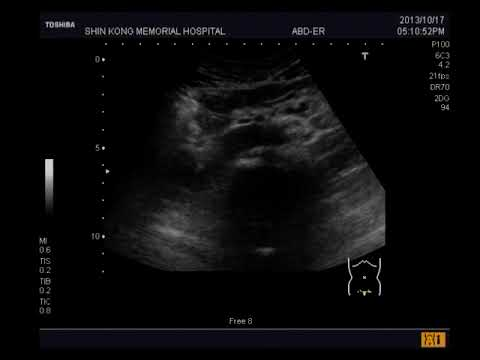

In [ ]:
# This is the video we're going to process
from IPython.display import YouTubeVideo, display
video = YouTubeVideo("blMIsY55DP0", width=500)
display(video)

In [ ]:
# Install dependencies, download the video, and crop 5 seconds for processing
!pip install youtube-dl
!youtube-dl https://www.youtube.com/watch?v=blMIsY55DP0 -f 22 -o video.mp4
!ffmpeg -i video.mp4 -t 00:00:06 -c:v copy video-clip.mp4

[youtube] blMIsY55DP0: Downloading webpage
[youtube] blMIsY55DP0: Downloading MPD manifest
ERROR: requested format not available
ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enab

In [ ]:
# Run frame-by-frame inference demo on this video (takes 3-4 minutes) with the "demo.py" tool we provided in the repo.
!git clone https://github.com/facebookresearch/detectron2
# Note: this is currently BROKEN due to missing codec. See https://github.com/facebookresearch/detectron2/issues/2901 for workaround.
%run detectron2/demo/demo.py --config-file detectron2/configs/COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml --video-input video-clip.mp4 --confidence-threshold 0.6 --output video-output.mkv \
  --opts MODEL.WEIGHTS detectron2://COCO-PanopticSegmentation/panoptic_fpn_R_101_3x/139514519/model_final_cafdb1.pkl

In [ ]:
# Download the results
from google.colab import files
files.download('video-output.mkv')